# Laboration maskininlärning AI22

## 1. Recommender system

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process


In [40]:
movies = "../labs/datasets/ml-latest/movies.csv"
ratings = "../labs/datasets/ml-latest/ratings.csv"

df_movies = pd.read_csv(movies, usecols=["movieId", "title", "genres"], dtype={"movieId" : "int32", "title" : "str", "genre" : "str"})
df_movies['year'] = df_movies['title'].str.extract('.*\((.*)\).*')
df_movies.head()


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [41]:
df_ratings = pd.read_csv(ratings, usecols=["userId", "movieId", "rating"], dtype={"userId":"int32", "movieId":"int32", "rating":"float32"})
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


### EDA

a) Summary - understanding the dataset

In [42]:
df_movies.describe()


,movieId
count,86537.000000
mean,155932.817096
std,78037.145347
min,1.000000
25%,111443.000000
50%,164574.000000
75%,211225.000000
max,288983.000000


In [43]:
df_movies.shape

(86537, 4)

In [44]:
df_ratings.describe()

,userId,movieId,rating
count,3.383216e+07,3.383216e+07,3.383216e+07
mean,1.654380e+05,2.831348e+04,3.542545e+00
std,9.534122e+04,4.992865e+04,1.063959e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,8.295300e+04,1.219000e+03,3.000000e+00
50%,1.661290e+05,3.263000e+03,4.000000e+00
75%,2.474500e+05,4.049100e+04,4.000000e+00
max,3.309750e+05,2.889830e+05,5.000000e+00


In [45]:
df_ratings.shape

(33832162, 3)

In [46]:
df_movies.isna().sum()

movieId      0
title        0
genres       0
year       615
dtype: int64

In [47]:
df_ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

b) Movies with the most ratings

In [48]:
top_10_movies = df_ratings['movieId'].value_counts().head(10)
top_10_movie_ids = top_10_movies.index

# Merge to get movie names
top_10_movie_names = pd.merge(pd.DataFrame(top_10_movie_ids, columns=['movieId']), df_movies, on='movieId')['title']

print("\nTop 10 movies with the most ratings:")
for i, (movie_id, movie_name, rating_count) in enumerate(zip(top_10_movie_ids, top_10_movie_names, top_10_movies)):
    print(f"{i+1}. {movie_name} - {rating_count} ratings")



Top 10 movies with the most ratings:
1. Shawshank Redemption, The (1994) - 122296 ratings
2. Forrest Gump (1994) - 113581 ratings
3. Pulp Fiction (1994) - 108756 ratings
4. Matrix, The (1999) - 107056 ratings
5. Silence of the Lambs, The (1991) - 101802 ratings
6. Star Wars: Episode IV - A New Hope (1977) - 97202 ratings
7. Fight Club (1999) - 86207 ratings
8. Schindler's List (1993) - 84232 ratings
9. Jurassic Park (1993) - 83026 ratings
10. Star Wars: Episode V - The Empire Strikes Back (1980) - 80200 ratings


c) average rating for the top 10 movies

In [49]:
# Step 2: Calculate the average rating for each movie
for movie_id, movie_name in zip(top_10_movie_ids, top_10_movie_names):
    movie_ratings = df_ratings[df_ratings['movieId'] == movie_id]['rating']
    average_rating = movie_ratings.mean()
    print(f"{movie_name}: {average_rating:.2f}")

Shawshank Redemption, The (1994): 4.42
Forrest Gump (1994): 4.07
Pulp Fiction (1994): 4.19
Matrix, The (1999): 4.16
Silence of the Lambs, The (1991): 4.15
Star Wars: Episode IV - A New Hope (1977): 4.09
Fight Club (1999): 4.24
Schindler's List (1993): 4.24
Jurassic Park (1993): 3.69
Star Wars: Episode V - The Empire Strikes Back (1980): 4.12


d) Movie Release Year Distribution

In [50]:
df_movies["year"] = df_movies['title'].str.extract('.*\((.*)\).*')
df_movies["year"]

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
86532    2021
86533    2021
86534    1973
86535    2023
86536    2021
Name: year, Length: 86537, dtype: object

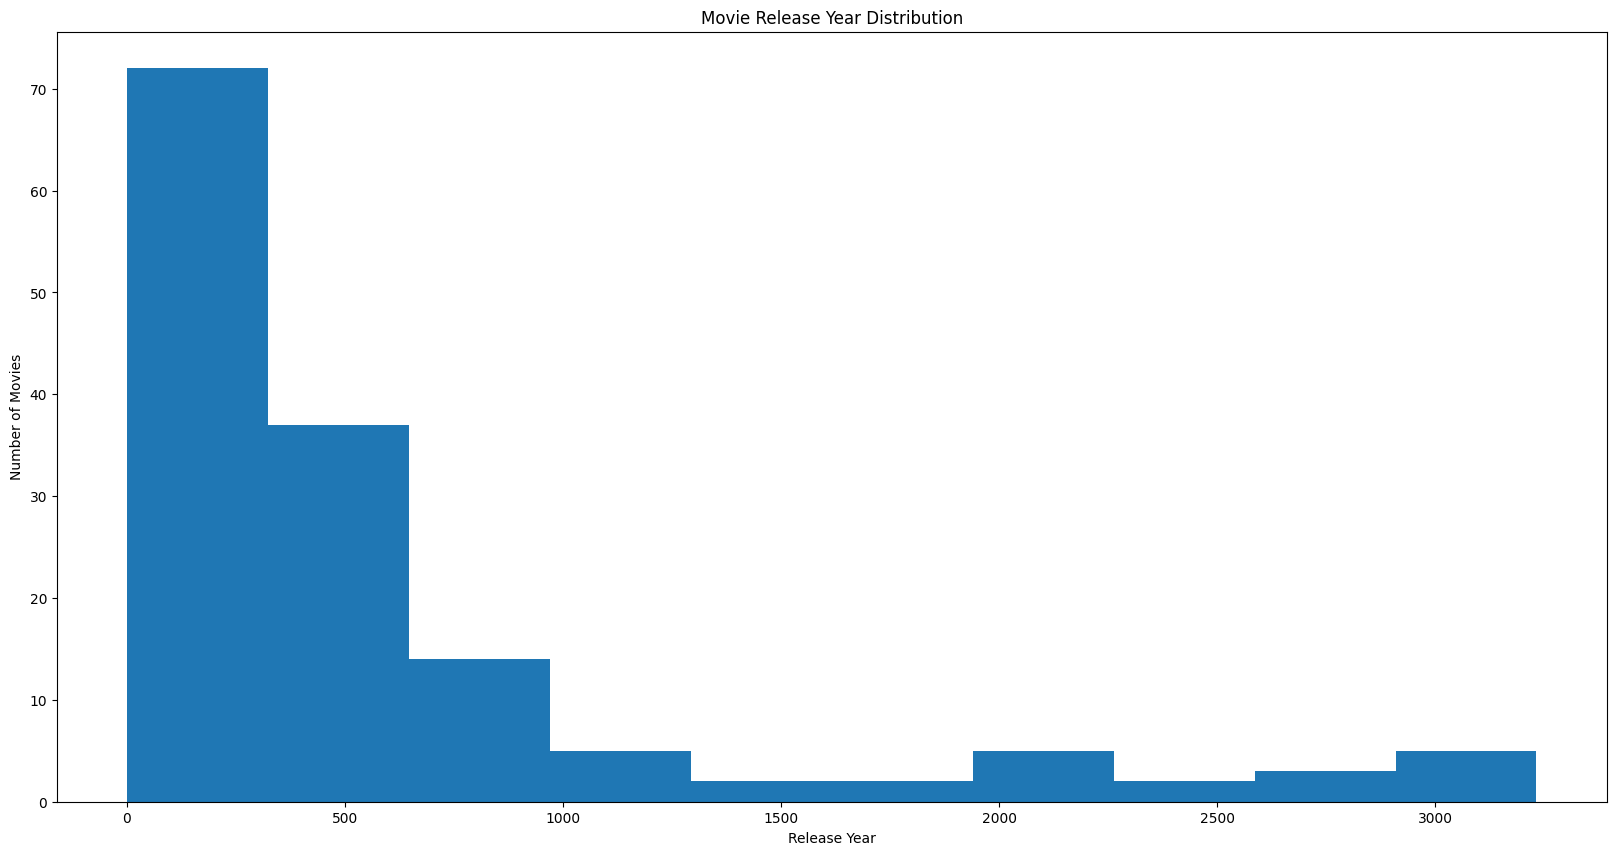

In [51]:
# Plotting

plt.figure(figsize=(20,10))
df_movies["year"].value_counts().sort_index().plot(kind="hist")
plt.title("Movie Release Year Distribution")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.show()

e) Distribution number of ratings x movie ID

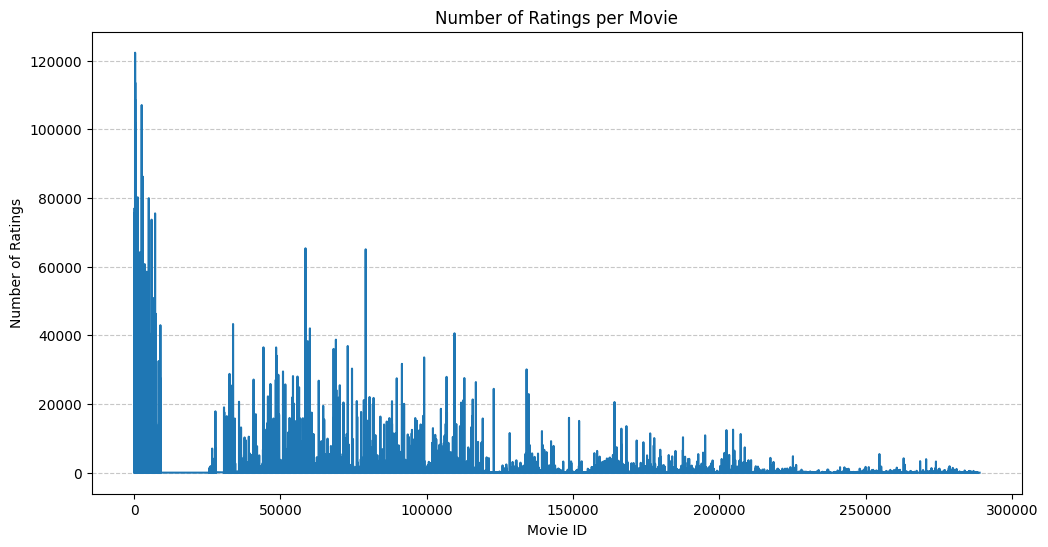

In [52]:
# Counting the number of ratings per movie
ratings_per_movie = df_ratings['movieId'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12,6))
plt.plot(ratings_per_movie.index, ratings_per_movie.values)
plt.title('Number of Ratings per Movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Distribution of Genres

In [53]:
# Extracting genres using Apply() method
genres = df_movies['genres'].apply(lambda x: pd.Series(x.split('|'))).stack().value_counts()
genres

Drama                 33681
Comedy                22830
Thriller              11675
Romance               10172
Action                 9563
Documentary            9283
Horror                 8570
(no genres listed)     7060
Crime                  6917
Adventure              5349
Sci-Fi                 4850
Animation              4579
Children               4367
Mystery                3972
Fantasy                3821
War                    2301
Western                1690
Musical                1059
Film-Noir               354
IMAX                    195
Name: count, dtype: int64

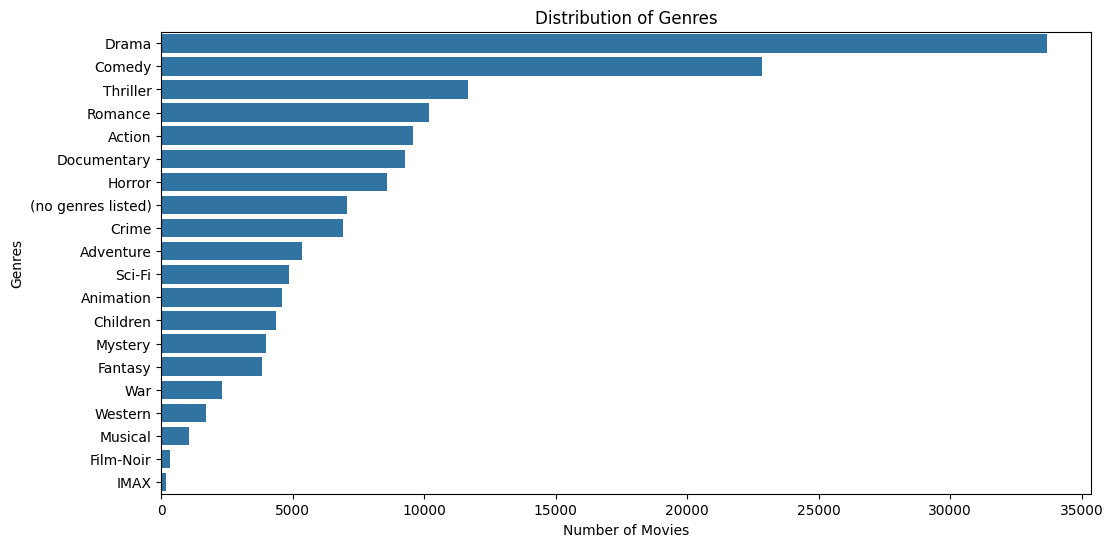

In [54]:
# Plotting 
plt.figure(figsize=(12,6))
sns.barplot(x=genres.values, y=genres.index)
plt.title("Distribution of Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.show()

f) bar plot of the average ratings for the top 10 movies

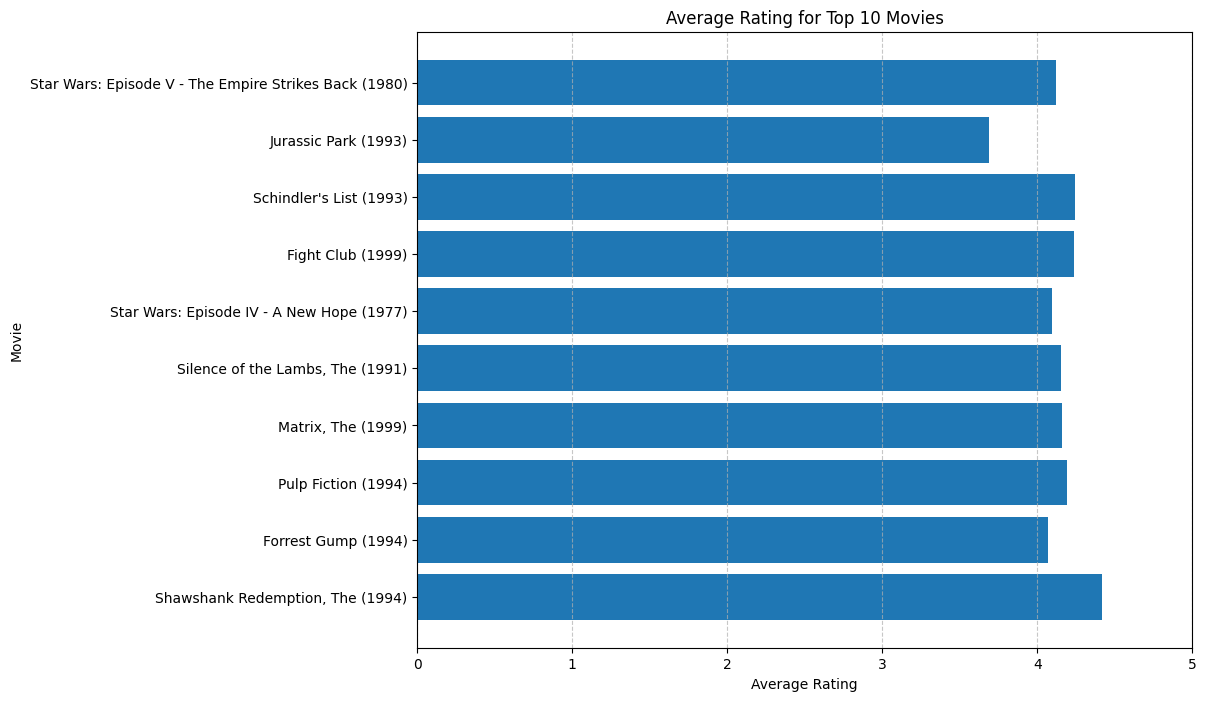

In [55]:

average_ratings = []
for movie_id, movie_name in zip(top_10_movie_ids, top_10_movie_names):
    movie_ratings = df_ratings[df_ratings['movieId'] == movie_id]['rating']
    average_rating = movie_ratings.mean()
    average_ratings.append(average_rating)

# Plotting
plt.figure(figsize=(10,8))
plt.barh(top_10_movie_names, average_ratings)
plt.title('Average Rating for Top 10 Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, 5)  # Setting the x-axis limit from 0 to 5
plt.show()


### 2. Sparse Matrix

Considering the "low performance" of my device + already tackling on the logical error suggested on the video, I choose a different approach for this system:

1. We take input from the user for the movie title.
2. Based on the input movie's genre, we filter the dataset to include only movies with the same genre.
3. If the genre is Drama, we further filter the dataset to include only movies from the same year as the input movie. (Since there are nearly 35000 movies in this genre)
4. If the genre is Comedy, we further filter the dataset to include only movies from the same decade as the input movie.(The second largest data subset in the dataframe)
5. We then pivot the table, convert it to a sparse matrix, fit the KNN model, and run the recommender function to provide recommendations based on the input movie.

In [147]:
df_merged = pd.merge(df_movies, df_ratings, on='movieId', how='left')

df_merged.shape

(26267438, 6)

Downscaling of df_ratings and df_movies

In [148]:
# Filter movies rated by at least 50 users
movie_counts = df_ratings['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= 50].index

# Filter users who have rated at least 100 movies
user_counts = df_ratings['userId'].value_counts()
filtered_users = user_counts[user_counts >= 100].index

# Filter movies and ratings based on the counts
df_movies = df_movies[df_movies['movieId'].isin(filtered_movies)]
df_ratings = df_ratings[df_ratings['userId'].isin(filtered_users)]

# Merge the filtered DataFrames
df_merged = pd.merge(df_movies, df_ratings, on='movieId', how='left')

df_merged.shape

(26248658, 6)

In [161]:
# User input and fuzzy matching (unchanged)
movie_title = input("Enter the title of a movie: ")
matched_title = process.extractOne(movie_title, df_movies['title'])[0]

print("Matched Title:", matched_title)

Matched Title: Toy Story (1995)


In [162]:
# Filter based on matched title
filtered_movie = df_merged[df_merged['title'] == matched_title]

if filtered_movie.empty:
  print("No movie found with the given title. Please try again.")
else:
  # Extract genre from the input movie
  input_genre = filtered_movie['genres'].values[0]

  # Filter movies based on genre (assuming no year filtering)
  filtered_movies = df_merged[df_merged['genres'] == input_genre]
  
filtered_movies.describe()

,movieId,userId,rating
count,156068.000000,156068.000000,156068.000000
mean,27955.692371,165569.054367,3.673363
std,63211.294758,95438.391242,0.980722
min,1.000000,7.000000,0.500000
25%,1.000000,83282.000000,3.000000
50%,3114.000000,165569.000000,4.000000
75%,4886.000000,248078.000000,4.500000
max,286131.000000,330975.000000,5.000000


In [163]:
from scipy.sparse import csc_matrix

movies_users = filtered_movies.pivot(index="movieId", columns="userId", values="rating").fillna(0)
movies_users


userId,7,10,14,21,22,24,35,40,44,51,...,330923,330931,330933,330938,330941,330942,330947,330961,330972,330975
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,2.5,3.0,0.0,4.5,4.0,0.0,3.5,5.0,...,0.0,0.0,4.0,0.0,0.0,0.0,5.0,4.0,3.0,2.5
2294,4.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.5
3114,0.0,2.5,0.0,3.0,0.0,4.5,4.5,4.5,3.5,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.5
3754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4016,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4886,0.0,3.5,0.0,0.0,4.5,3.5,5.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.5,5.0,4.5,0.0,2.5
33463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53121,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
mat_movies_users = csr_matrix(movies_users.values)
mat_movies_users

<30x59642 sparse matrix of type '<class 'numpy.float32'>'
	with 156068 stored elements in Compressed Sparse Row format>

In [165]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20)
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [169]:
def recommender(movie_title, mat_movies_users, model_knn, n_recommendations, df_movies):

    # 1. Find Movie ID (Assuming movie titles are present)
    movie_id = df_movies[df_movies["title"] == matched_title]["movieId"].values.squeeze()

    # 2. Handle Missing Movie Title
    if not movie_id:
        print(f"Movie '{movie_title}' not found in data.")
        return

    # 3. Get Movie User Ratings as a Sparse Vector
    movie_user_ratings = mat_movies_users[movie_id].toarray().squeeze()

    # 4. Use KNN to Find Similar Movies
    distances, indices = model_knn.kneighbors(movie_user_ratings.reshape(1, -1))

    # 5. Extract Recommended Movie Titles (Assuming movie IDs lead to titles)
    recommended_movie_ids = df_movies.loc[indices[0]]["movieId"].tolist()
    recommended_titles = [df_movies.loc[idx]["title"] for idx in recommended_movie_ids]

    # 6. Exclude Original Movie from Recommendations
    recommended_titles = [title for title in recommended_titles if title != movie_title]

    # 7. Display Recommendations
    print(f"Recommendations for '{movie_title}':")
    for i in range(min(n_recommendations, len(recommended_titles))):
        print(f"- {recommended_titles[i]}")

# Example Usage (assuming you have movie_title, mat_movies_users, model_knn, n_recommendations, and df_movies defined)
recommender(movie_title, mat_movies_users, model_knn, 5, df_movies)

Recommendations for 'Toy Story':
- Grumpier Old Men (1995)
- Waiting to Exhale (1995)
- Jumanji (1995)
- Sabrina (1995)
- Heat (1995)


### Recommender Function

### - 1.3 a) Description on how the system works

This system prioritises both device performance and recommending thematically similar films. I tried something different by firstly taking the user input, and then downsizing the large dataset into smaller subsets. I based certain decisions after studying the EDA. On more technical notes, the system achieves this by constructing a sparse matrix for efficient user-rating storage. This matrix facilitates a K-Nearest Neighbors (KNN) model in identifying movies akin to a user's selection based on rating patterns. Notably, unlike the video example, this approach doesn't explicitly consider factors like movie title, but rather time-period and/or genre, which could potentially be integrated to refine recommendation accuracy.

### b) Recommender Systems

Recommender systems leverage machine learning to personalize user experiences by suggesting relevant products or content. At the heart lies user data analysis, encompassing explicit actions (purchases, ratings) and implicit signals (browsing history, time spent). These systems identify user preferences through two main approaches:

Collaborative Filtering: This technique focuses on user-to-user similarities. Machine learning algorithms, like matrix factorization, analyze user-item interaction data to uncover hidden factors that explain user preferences. By identifying users with similar tastes, the system recommends items those users enjoyed. 

Content-Based Filtering: This approach focuses on item attributes.  The system employs techniques like vector embeddings to represent both items and user preferences in a shared vector space.  This allows for comparisons between items based on their features. For instance, a music streaming service might analyze audio properties and recommend songs similar to those you've listened to in the past.

Sources: 

https://www.technologyreview.com/2022/04/27/1048517/the-recommender-revolution/

https://medium.com/@toprak.mhmt/collaborative-filtering-3ceb89080ade